# k-means-clustering from scratch
In This notebook we write our own k-means from scratch in Python and apply it to predict the survivability on the famous Titanic dataset. The method is very similar to k-nearest-neighbor, however now we find groups of similar data.

### Content
1. Create a k-means algorithm
2. Predict Titanic Survivabillity
3. Solution using Scikit-Learn

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a k-means algorithm

Lets first generate a toy dataset to apply k-means on:

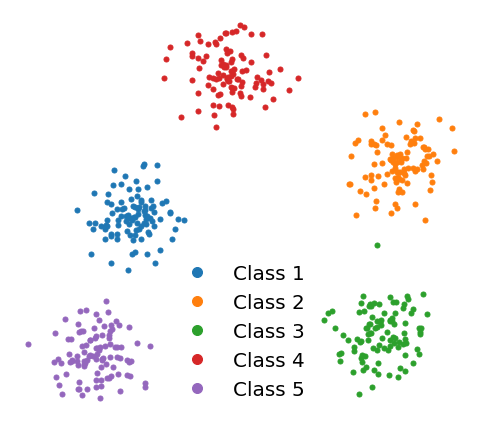

In [46]:
lower, higher = -10, 10
points = 100
clusters = 5
width = 1.2
random_state = 1

np.random.seed(random_state)

data = []
for ix in range(clusters):
    cx, cy = np.random.randint(lower, higher), np.random.randint(lower, higher), 
    x = np.random.normal(cx, width, size=(points,))
    y = np.random.normal(cy, width, size=(points,))
    data.append(
        pd.DataFrame({
            'x': x,
            'y': y,
            'label': ix + 1,
        })
    )
data = pd.concat(data)

X = data.drop('label', axis=1)
y = data.drop(['x', 'y'], axis=1)

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.set_aspect('equal')
plt.axis('off')
fig.tight_layout()
for group, group_data in data.groupby('label'):
    plt.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group}')
lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)

Next, we need to define a distance function. A very common function is the Euclidean distance.

In [47]:
def euclidean_distance(vector1, vector2):
    return np.sqrt(np.sum((vector1 - vector2)**2))

# test function
vec1 = np.array([3, 0])
vec2 = np.array([0, 4])

# this is the 3:4:5 triangle and therefore, it should return 5 (Long live Pythagoras)
euclidean_distance(vec1, vec2)

5.0

The euclidean distance calculates the square root, however, the squared distance is very similar and computationally a bit easier.

In [48]:
def squared_difference(dataset, vector, columns=['x', 'y']):
    return ((dataset[columns[0]] - vector[columns[0]])**2 +
                  (dataset[columns[1]] - vector[columns[1]])**2)

As we already know the amount of clusters, lets just set that. For k-means we need a starting point. We will randomly select the number of clusters amount of points from our dataset.

In [49]:
number_of_clusters = len(y.label.unique())
centroids = X.sample(number_of_clusters, random_state=random_state)
number_of_clusters

5

Next we need a function to cluster our dataset according to the center points we have randomly chosen.

In [50]:
def cluster_dataset(dataset, centroids):
    distances = pd.concat([
        ((dataset - centroid)**2).sum(axis=1)
        for ix, centroid in centroids.iterrows()],
        axis=1,
    )
    return dataset.assign( cluster = distances.idxmin(axis=1)), distances.min(axis=1).sum()

In [51]:
clustered, _ = cluster_dataset(X, centroids)

In [52]:
clustered.cluster.unique()

array([2, 3, 1, 0, 4])

Lets plot our clustered dataset and include the centers:

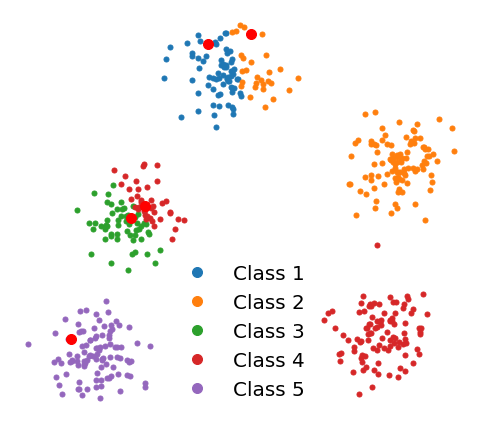

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.set_aspect('equal')
plt.axis('off')
fig.tight_layout()
for group, group_data in clustered.groupby('cluster'):
    plt.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group + 1}')

for ix, centroid in centroids.iterrows():
    ax.plot(centroid.x, centroid.y, 'ro', ms=10)
lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)
# xlim = ax.set_xlim([-5, 26])    


The next step in k-means is to update the centroids to have the center averaged over the found cluster. This will move the centroids to the new position and we can repeat this step to converge to the perfect position.

In [54]:
def update_centroids(clustered_dataset):
    new_centroids = clustered_dataset.groupby('cluster').mean().reset_index(drop=True)
    return new_centroids


In [55]:
centroids = update_centroids(clustered)

In [56]:
centroids

,x,y
0,-0.493259,8.678160
1,7.309840,5.134415
2,-5.444337,0.765061
3,4.590739,-2.903448
4,-6.842355,-5.943509


We can visualize this in steps:

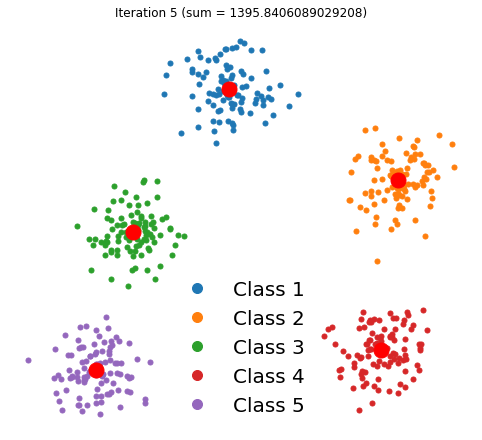

In [64]:
from time import sleep
from IPython.display import clear_output

def plot(clustered, centroids, iteration, total_sum):
    clear_output(wait=True)
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.set_aspect('equal')
    plt.axis('off')
    fig.tight_layout()
    for group, group_data in clustered.groupby('cluster'):
        ax.plot(group_data.x, group_data.y, 'o', ms=5, label=f'Class {group + 1}')
    for ix, centroid in centroids.iterrows():
        ax.plot(centroid.x, centroid.y, 'ro', ms=15)
    lgd = ax.legend(loc=8, fontsize=20, frameon=False, markerscale=2)
    ax.set_title(f'Iteration {iteration} (sum = {total_sum})')
    plt.show()

    
def cluster_data(dataset, number_of_clusters, max_iter=20, show=False, pause=0.5):
    ds = dataset.copy()
    centroids = ds.sample(number_of_clusters, random_state=random_state)
    previous_sum = pd.Series(range(len(centroids)))
    for iteration in range(max_iter):
        clustered, total_sum = cluster_dataset(ds, centroids)
        centroids = update_centroids(clustered)
        if show:
            plot(clustered, centroids, iteration + 1, total_sum)
            sleep(pause)
        if (total_sum - previous_sum).sum() == 0:  # this is not the best method
            break
        previous_sum = total_sum
    return clustered, centroids, total_sum
            
clust, cent, total_sum = cluster_data(X, number_of_clusters= 5, show=True)

This is a great method to identify groups, however we need to provide the amount of clusters. One way to select this amount is using the Elbow method. This is a visual method in which we plot the average distance of all datapoints to their centroids as function of number of clusters (k). These will go down fast in the beginning and eventually converge to a flat line. This is because we get clusters with only one or a few points and it cannot get much better. The "elbow" of the graph, i.e. the corner is approximately the best k-value. For this, we do need to have the proper distance, i.e. the euclidean distance, as we are summing many distances.

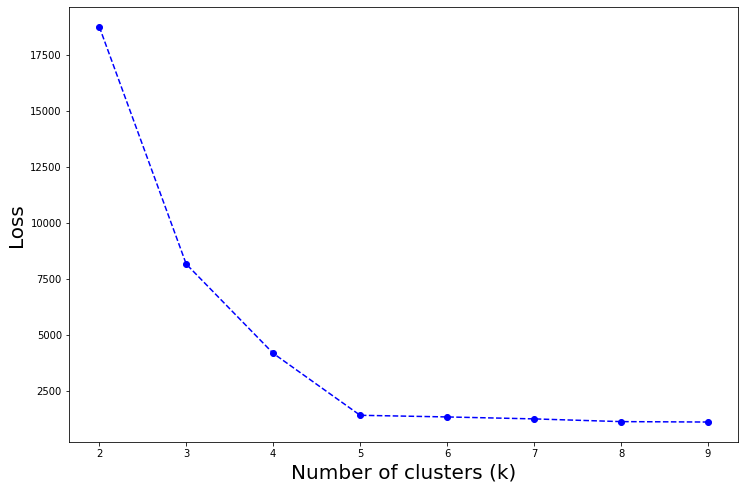

In [65]:
result = {}
for num_of_clust in range(2, 10):
    clust, cent, total_sum = cluster_data(X, number_of_clusters=num_of_clust, show=False)
    result[num_of_clust] = total_sum
    
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(list(result.keys()), list(result.values()), 'bo--')
_ = ax.set_xlabel('Number of clusters (k)', fontsize=20)
_ = ax.set_ylabel('Loss', fontsize=20)

In [59]:
result.values()

dict_values([18765.41979096566, 8155.317646862755, 4165.355556291486, 1395.8406089029208, 1322.012841316648, 1234.5558316259371, 1112.8605589831325, 1094.3048536269732])

The elbow of the graph is around 5, which is exactly the amount of clusters we defined in the beginning. Of course, this is a very nice toy dataset and with real data this might not be so clear. Still, nice to have a confirmation!

In [60]:
import os
os.getcwd()

'/home/nexnt/projects/T809DATA_2021/11_k_means'

# 2. Predict Titanic Survivabillity

We start with the dataset we have created during my KNN Notebook:

In [69]:
import pyarrow
import fastparquet

combined = pd.read_parquet('titanic_family_survivabillity.parquet')

train = combined.loc[combined['set'] == 'train'].drop('set', axis=1).reset_index(drop=True)
test = combined.loc[combined['set'] == 'test'].drop(['set', 'Survived'], axis=1).reset_index(drop=True)
train['Survived'] = train['Survived'].astype(np.int)

columns = ['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']

In [70]:
clust, cent, total_sum = cluster_data(train[columns], number_of_clusters=100)

clust['Survived'] = train['Survived']
survival_mapper = clust.groupby('cluster')['Survived'].mean().round().astype(np.int).to_dict()
clust['group_survived'] = clust.cluster.map(survival_mapper)
clust

,Pclass,Sex,Fare,family_survival,family_size,cluster,Survived,group_survived
0,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
1,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
2,-1.546098,-1.344995,1.415958,1.498350,-0.558346,7,1,1
3,-1.546098,0.743497,1.415958,1.498350,0.705051,5,0,0
4,-1.546098,-1.344995,1.415958,1.498350,0.705051,3,1,1
...,...,...,...,...,...,...,...,...
886,0.841916,-1.344995,-1.392358,-0.052117,-0.558346,13,0,1
887,-1.546098,0.743497,1.415958,-0.052117,0.073352,33,0,0
888,-0.352091,0.743497,-0.690279,1.498350,-0.558346,22,0,0
889,-1.546098,-1.344995,1.415958,-1.602583,0.705051,31,1,1


In [71]:
accuracy = (clust['Survived'] == clust['group_survived']).mean()
accuracy  # train dataset accuracy

0.8406285072951739

In [72]:
survival_map = clust.groupby('cluster')['Survived'].mean().round().astype(np.int).to_dict()

predict, loss = cluster_dataset(test[columns], cent)

predict['Survived'] = predict.cluster.map(survival_map)
predict['PassengerId'] = test['PassengerId']
predict = predict[['PassengerId', 'Survived']].sort_values('PassengerId').reset_index(drop=True)
predict

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [74]:
predict.to_csv('results_algorithm_from_scratch.csv', index=False)

On Kaggle, it scores 0.794. Not bad at all!

# 3. Solution using Scikit-Learn

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
km = KMeans(
    n_clusters=47,
    init='random',
    n_init=32,
    max_iter=600, 
    tol=1e-5,
    random_state=2020,
)

_ = km.fit(train[['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']])

NameError: name 'train' is not defined

In [ ]:
df = train.copy()
df['cluster'] = km.predict(df[columns])
mapper = df.groupby('cluster')['Survived'].mean().round().to_dict()

df = test.copy()
df['Survived'] = km.predict(test[['Pclass', 'Sex',  'Fare', 'family_survival', 'family_size']])
df['Survived'] = df.Survived.map(mapper).astype(np.int)
df = df[['PassengerId', 'Survived']].sort_values('PassengerId').reset_index(drop=True)

df.to_csv('results_scikit_algorithm.csv', index=False)

The Scikit-learn algorithm scores almost the same: 0.796